# **Load all toolboxs in this project**

In [ ]:
import numpy as np
import scipy.io as sio
from sklearn.utils import shuffle
import pathlib
from pathlib import Path
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random

import h5py
import zipfile

from IPython.display import clear_output, display # clear the output if needed

import tensorflow as tf
from tensorflow import keras
import tensorboard
from tensorflow.keras.models import model_from_json

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc,
)

from scipy.stats import randint as sp_randint
from scipy.stats import uniform
import traceback

%matplotlib inline

### Set up the working directory

In [ ]:
cwd = Path.cwd()

folder_raw_data = Path('data/raw/')
folder_processed_data = Path('data/processed/')
folder_models = Path('models/')

### Download dataset and TCN and best model in the original writers' github page

In [ ]:
if folder_raw_data.exists() == False:

    pathlib.Path(folder_raw_data).mkdir(parents=True, exist_ok=True)
    os.chdir(folder_raw_data)
    !wget 'https://ti.arc.nasa.gov/m/project/prognostic-repository/mill.zip'

os.chdir(cwd) # change back to root directory

if folder_processed_data.exists() == False:

    pathlib.Path(folder_processed_data).mkdir(parents=True, exist_ok=True)
    os.chdir(folder_processed_data)
    !wget 'https://raw.githubusercontent.com/tvhahn/ml-tool-wear/master/data/processed/labels_with_tool_class.csv'

    os.chdir(cwd)

    # download important python files into the main directory
    !wget 'https://raw.githubusercontent.com/tvhahn/ml-tool-wear/master/data_prep.py'
    !wget 'https://raw.githubusercontent.com/tvhahn/ml-tool-wear/master/tcn.py'
    !wget 'https://raw.githubusercontent.com/tvhahn/ml-tool-wear/master/threshold.py'


if folder_models.exists() == False:

    pathlib.Path(folder_models / 'best_models').mkdir(parents=True, exist_ok=True)
    pathlib.Path(folder_models / 'saved_models').mkdir(parents=True, exist_ok=True)
    os.chdir(folder_models / 'best_models')
    !wget 'https://github.com/tvhahn/ml-tool-wear/raw/master/models/best_models/best_models.zip'

    os.chdir(cwd)


# extract mill.mat from the zip file
with zipfile.ZipFile(folder_raw_data / 'mill.zip', 'r') as zip_ref:
    zip_ref.extractall(folder_raw_data)

# extract best models from the zip file
with zipfile.ZipFile(folder_models / 'best_models' / 'best_models.zip', 'r') as zip_ref:
    zip_ref.extractall(folder_models / 'best_models')

# import those packages that we just downloaded
import data_prep
import threshold
from tcn import TCN

--2021-12-12 23:20:48--  https://ti.arc.nasa.gov/m/project/prognostic-repository/mill.zip
Resolving ti.arc.nasa.gov (ti.arc.nasa.gov)... 128.102.105.66, 2001:4d0:6311:2227:14b6:372b:2078:2a94
Connecting to ti.arc.nasa.gov (ti.arc.nasa.gov)|128.102.105.66|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15140674 (14M) [application/zip]
Saving to: ‘mill.zip’

mill.zip            100%[===================>]  14.44M  19.8MB/s    in 0.7s    

2021-12-12 23:20:49 (19.8 MB/s) - ‘mill.zip’ saved [15140674/15140674]

--2021-12-12 23:20:49--  https://raw.githubusercontent.com/tvhahn/ml-tool-wear/master/data/processed/labels_with_tool_class.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6449 (6.3K) [text/plain]
Saving to: ‘labels_with_tool_

In [ ]:
# Create the data preprocessing function we need:

def scaler(x, min_val_array, max_val_array):
    # get the shape of the array
    s, _, sub_s = np.shape(x)

    for i in range(s):
        for j in range(sub_s):
            x[i, :, j] = np.divide(
                (x[i, :, j] - min_val_array[j]),
                np.abs(max_val_array[j] - min_val_array[j]),
            )

    return x

In [ ]:
#Create min-max function
def get_min_max(x):
    flat_vector = np.concatenate(x)
    min_vals = np.min(flat_vector, axis=0)
    max_vals = np.max(flat_vector, axis=0)

    return min_vals, max_vals

In [ ]:
# Define a function for load the dataset from the ogrinal paper github page:
def load_train_test(directory):
    '''
    Function to quickly load the train/val/test data splits
    '''

    path = directory

    with h5py.File(path / "X_train.hdf5", "r") as f:
        X_train = f["X_train"][:]
    with h5py.File(path / "y_train.hdf5", "r") as f:
        y_train = f["y_train"][:]

    with h5py.File(path / "X_train_slim.hdf5", "r") as f:
        X_train_slim = f["X_train_slim"][:]
    with h5py.File(path / "y_train_slim.hdf5", "r") as f:
        y_train_slim = f["y_train_slim"][:]

    with h5py.File(path / "X_val.hdf5", "r") as f:
        X_val = f["X_val"][:]
    with h5py.File(path / "y_val.hdf5", "r") as f:
        y_val = f["y_val"][:]

    with h5py.File(path / "X_val_slim.hdf5", "r") as f:
        X_val_slim = f["X_val_slim"][:]
    with h5py.File(path / "y_val_slim.hdf5", "r") as f:
        y_val_slim = f["y_val_slim"][:]

    with h5py.File(path / "X_test.hdf5", "r") as f:
        X_test = f["X_test"][:]
    with h5py.File(path / "y_test.hdf5", "r") as f:
        y_test = f["y_test"][:]

    return (
        X_train,
        y_train,
        X_train_slim,
        y_train_slim,
        X_val,
        y_val,
        X_val_slim,
        y_val_slim,
        X_test,
        y_test,
    )

In [ ]:
# functions needed for VAE sampling in the latent space
K = keras.backend

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean


In [ ]:
# rounded accuracy for the metric
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

### Load dataset

In [ ]:
# load the data from the matlab file
m = sio.loadmat(folder_raw_data / 'mill.mat',struct_as_record=True)

# store the 'mill' data in a seperate np array
data = m['mill']

### Create dataframe file about the raw data

In [ ]:
# store the field names in the data np array in a tuple, l
l = data.dtype.names

# create empty dataframe for the labels
df_labels = pd.DataFrame()

# get the labels from the original .mat file and put in dataframe
for i in range(7):
    # list for storing the label data for each field
    x = []

    # iterate through each of the unique cuts
    for j in range(167):
        x.append(data[0,j][i][0][0])
    x = np.array(x)
    df_labels[str(i)] = x

# add column names to the dataframe
df_labels.columns = l[0:7]

# create a column with the unique cut number
df_labels['cut_no'] = [i for i in range(167)]

df_labels.head()

,case,run,VB,time,DOC,feed,material,cut_no
0,1,1,0.00,2,1.5,0.5,1,0
1,1,2,NaN,4,1.5,0.5,1,1
2,1,3,NaN,6,1.5,0.5,1,2
3,1,4,0.11,7,1.5,0.5,1,3
4,1,5,NaN,11,1.5,0.5,1,4


### **Visualize the raw dataset**

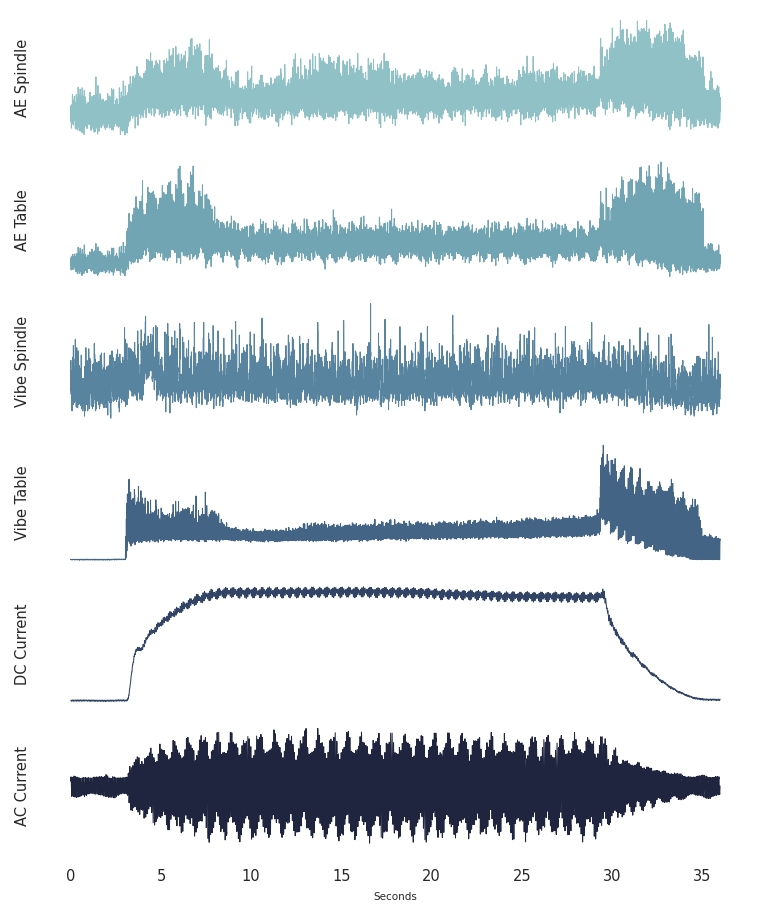

In [ ]:
def plot_cut(cut_signal, signals_trend, cut_no):

    # define colour palette and seaborn style
    pal = sns.cubehelix_palette(6, rot=-0.25, light=0.7)
    sns.set(style="white", context="notebook")

    fig, axes = plt.subplots(
        6, 1, dpi=150, figsize=(5, 6), sharex=True, constrained_layout=True,
    )

    # the "revised" signal names so it looks good on the chart
    signal_names_revised = [
        "AE Spindle",
        "AE Table",
        "Vibe Spindle",
        "Vibe Table",
        "DC Current",
        "AC Current",
    ]

    # go through each of the signals
    for i in range(6):
        # plot the signal
        # note, we take the length of the signal (9000 data point)
        # and divide it by the frequency (250 Hz) to get the x-axis
        # into seconds
        axes[i].plot(np.arange(0,9000)/250.0,
                     cut_signal[signals_trend[i]],
                     color=pal[i],
                     linewidth=0.5,
                     alpha=1)

        axis_label = signal_names_revised[i]

        axes[i].set_ylabel(
            axis_label, fontsize=7,
        )

        # if it's not the last signal on the plot
        # we don't want to show the subplot outlines
        if i != 5:
            axes[i].spines["top"].set_visible(False)
            axes[i].spines["right"].set_visible(False)
            axes[i].spines["left"].set_visible(False)
            axes[i].spines["bottom"].set_visible(False)
            axes[i].set_yticks([]) # also remove the y-ticks, cause ugly

        # for the last signal we will show the x-axis labels
        # which are the length (in seconds) of the signal
        else:
            axes[i].spines["top"].set_visible(False)
            axes[i].spines["right"].set_visible(False)
            axes[i].spines["left"].set_visible(False)
            axes[i].spines["bottom"].set_visible(False)
            axes[i].set_yticks([])
            axes[i].tick_params(axis="x", labelsize=7)
            axes[i].set_xlabel('Seconds', size=5)


signals_trend = list(l[7:])  # there are 6 types of signals, smcAC to AE_spindle
signals_trend = signals_trend[::-1]  # reverse the signal order so that it is matching other charts

# we'll plot signal 146 (index 145)
cut_signal = data[0, 145]

plot_cut(cut_signal, signals_trend, "cut_146")
# plt.savefig('cut_signals.png',format='png') # save the figure
plt.show()

### Generate the sub_cut signal with the window size = 64 and stride = 64

In [ ]:
data_file = folder_raw_data / "mill.mat"

prep = data_prep.DataPrep(data_file)

# load the labeled CSV (NaNs filled in by hand)
df_labels = pd.read_csv(
    folder_processed_data / 'labels_with_tool_class.csv'
)


# discard certain cuts as they are strange
cuts_remove = [17, 94]
df_labels.drop(cuts_remove, inplace=True)


X, y, dfy = prep.return_xy(df_labels, prep.data,prep.field_names[7:],window_size=64, stride=64, track_y=True)

X_train, X_test, dfy_train, dfy_test = train_test_split(X, dfy, test_size=0.33, random_state=15,
                                                    stratify=dfy['class'])
X_val, X_test, dfy_val, dfy_test = train_test_split(X_test, dfy_test, test_size=0.50, random_state=10,
                                                stratify=dfy_test['class'])

y_train = dfy_train['class'].to_numpy(dtype='int')
y_val = dfy_val['class'].to_numpy(dtype='int')
y_test = dfy_test['class'].to_numpy(dtype='int')


min_vals, max_vals = get_min_max(X_train)

# scale the data sets
X = scaler(X, min_vals, max_vals)
X_train = scaler(X_train, min_vals, max_vals)
X_val = scaler(X_val, min_vals, max_vals)
X_test = scaler(X_test, min_vals, max_vals)


Show the size of the training dataset

In [ ]:
# pick up full health signal from the full X_train and X_val
X_train_slim, y_train_slim = prep.remove_classes([1, 2], y_train, X_train)

print("\nShape of X_train_health:", X_train_slim.shape)
print("Shape of y_train_health:", y_train_slim.shape)

X_val_slim, y_val_slim = prep.remove_classes([1, 2], y_val, X_val)

print("\nShape of X_val_health:", X_val_slim.shape)
print("Shape of y_val_health:", y_val_slim.shape)

print("\nShape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

signal_names = prep.field_names[7:] # get signal names
signal_names = signal_names[::-1] # reverse order so that it is same as in data structure


Shape of X_train_health: (2831, 64, 6)
Shape of y_train_health: (2831,)

Shape of X_val_health: (697, 64, 6)
Shape of y_val_health: (697,)

Shape of X_test: (1910, 64, 6)
Shape of y_test: (1910,)


Check the version of tensorflow and working with google colab online free GPU

In [ ]:
# see what version of tensorflow is installed
print('TensorFlow version: ', tf.__version__)
print('Keras version: ', keras.__version__)
print('Tensorboard version:', tensorboard.__version__)

TensorFlow version:  2.7.0
Keras version:  2.7.0
Tensorboard version: 2.7.0


In [ ]:
# see if you're using a GPU. You don't have to, but it
# will be faster if you're training many models
try:
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))
except:
    print('GPU device not found')

Found GPU at: /device:GPU:0


### Create the model according to the framework shown in the report. This is directly git clone form the TCN github page, so we can directly design our model

In [ ]:

# fit the model
def model_fit(
    X_train_slim,
    X_val_slim,
    beta_value=1.25,
    codings_size=10,
    dilations=[1, 2, 4],
    conv_layers=1,
    seed=31,
    start_filter_no=32,
    kernel_size_1=2,
    epochs=10,
    earlystop_patience=8,
    verbose=0,
    compile_model_only=False,
):

    # try the first if it is the milling data
    # else it will be the CNC data
    try:
        _, window_size, feat = X_train_slim.shape

    except:
        window_size = X_train_slim.shape
        feat = 1

    date_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    tf.random.set_seed(seed)
    np.random.seed(seed)

    end_filter_no = start_filter_no

    inputs = keras.layers.Input(shape=[window_size, feat])
    z = inputs

    # ENCODER
    ####### TCN #######
    for i in range(0, conv_layers):
        z = TCN(
            nb_filters=start_filter_no,
            kernel_size=kernel_size_1,
            nb_stacks=1,
            dilations=dilations,
            padding="causal",
            use_skip_connections=True,
            dropout_rate=0.0,
            return_sequences=True,
            activation="selu",
            kernel_initializer="he_normal",
            use_batch_norm=False,
            use_layer_norm=False,
        )(z)

        z = keras.layers.BatchNormalization()(z)
        z = keras.layers.MaxPool1D(pool_size=2)(z)

    z = keras.layers.Flatten()(z)
    print("Shape of Z:", z.shape)

    codings_mean = keras.layers.Dense(codings_size)(z)

    codings_log_var = keras.layers.Dense(codings_size)(z)

    codings = Sampling()([codings_mean, codings_log_var])

    variational_encoder = keras.models.Model(
        inputs=[inputs], outputs=[codings_mean, codings_log_var, codings]
    )

    # DECODER
    decoder_inputs = keras.layers.Input(shape=[codings_size])

    x = keras.layers.Dense(
        start_filter_no * int((window_size / (2 ** conv_layers))), activation="selu"
    )(decoder_inputs)

    x = keras.layers.Reshape(
        target_shape=((int(window_size / (2 ** conv_layers))), end_filter_no)
    )(x)

    for i in range(0, conv_layers):
        x = keras.layers.UpSampling1D(size=2)(x)
        x = keras.layers.BatchNormalization()(x)

        x = TCN(
            nb_filters=start_filter_no,
            kernel_size=kernel_size_1,
            nb_stacks=1,
            dilations=dilations,
            padding="causal",
            use_skip_connections=True,
            dropout_rate=0.0,
            return_sequences=True,
            activation="selu",
            kernel_initializer="he_normal",
            use_batch_norm=False,
            use_layer_norm=False,
        )(x)

    outputs = keras.layers.Conv1D(
        feat, kernel_size=kernel_size_1, padding="same", activation="sigmoid"
    )(x)
    variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

    _, _, codings = variational_encoder(inputs)
    reconstructions = variational_decoder(codings)
    variational_ae_beta = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

    latent_loss = (
        -0.5
        * beta_value
        * K.sum(
            1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
            axis=-1,
        )
    )

    variational_ae_beta.add_loss(K.mean(latent_loss) / (window_size * feat))
    variational_ae_beta.compile(
        loss="binary_crossentropy",
        optimizer="adam",  #'rmsprop'
        metrics=[rounded_accuracy],
    )

    # count the number of parameters
    param_size = "{:0.2e}".format(
        variational_encoder.count_params() + variational_decoder.count_params()
    )

    # Uncomment these if you want to see the summary of the encoder/decoder
    # variational_encoder.summary()
    # variational_decoder.summary()

    # Model Name
    # b : beta value used in model
    # c : number of codings -- latent variables
    # l : numer of convolutional layers in encoder (also decoder)
    # f1 : the starting number of filters in the first convolution
    # k1 : kernel size for the first convolution
    # k2 : kernel size for the second convolution
    # d : whether dropout is used when sampling the latent space (either True or False)
    # p : number of parameters in the model (encoder + decoder params)
    # eps : number of epochs
    # pat : patience stopping number

    model_name = (
        "TBVAE-{}:_b={:.2f}_c={}_l={}_f1={}_k1={}_dil={}"
        "_p={}_eps={}_pat={}".format(
            date_time,
            beta_value,
            codings_size,
            conv_layers,
            start_filter_no,
            kernel_size_1,
            dilations,
            param_size,
            epochs,
            earlystop_patience,
        )
    )

    print("\n", model_name, "\n")

    if compile_model_only == False:
        # save the model summary into a text file (from stack overflow http://bit.ly/2DHI6fM)
        with open("models/saved_models/" + date_time + "_report.txt", "w") as fh:
            variational_encoder.summary(print_fn=lambda x: fh.write(x + "\n"))
            variational_decoder.summary(print_fn=lambda x: fh.write(x + "\n"))

        # # use tensorboard to track training
        # log_dir = "logs/" + date_time + "_" + model_name
        # tensorboard_callback = tf.keras.callbacks.TensorBoard(
        #     log_dir=log_dir, histogram_freq=0, update_freq="epoch", profile_batch=0
        # )

        earlystop_callback = tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=0.0002,
            patience=earlystop_patience,
            restore_best_weights=True,
            verbose=1,
        )

        history = variational_ae_beta.fit(
            X_train_slim,
            X_train_slim,
            epochs=epochs,
            batch_size=1024,
            shuffle=True,
            validation_data=(X_val_slim, X_val_slim),
            callbacks=[earlystop_callback,],  # tensorboard_callback,
            verbose=verbose,
        )

        return date_time, model_name, history, variational_ae_beta, variational_encoder

    else:

        return variational_ae_beta, variational_encoder

Load the dataset

In [ ]:
# load the data splits
(X_train, y_train,
X_train_slim, y_train_slim,
X_val, y_val,
X_val_slim, y_val_slim,
X_test,y_test) = load_train_test(folder_processed_data)

In [ ]:
# reload the data sets
(X_train, y_train,
X_train_slim, y_train_slim,
X_val, y_val,
X_val_slim, y_val_slim,
X_test,y_test) = load_train_test(folder_processed_data)

In [ ]:
# function to show the percentage of labels in y-labels
def y_shape_percentage(y_train, label):

    l = y_train

    print('shape {}:'.format(label), l.shape,
          '\t\t0: {:.1%}'.format(len(l[l == 0])/len(l)),
          '\t\t1: {:.1%}'.format(len(l[l == 1])/len(l)),
          '\t\t2: {:.1%}'.format(len(l[l == 2])/len(l)))

# let's see what percentage of the data set splits are made up of healthy (0), degraded (1),
# and failed (2) labels
y_shape_percentage(y_train_slim, 'y_train')
y_shape_percentage(y_val_slim, 'y_val')
y_shape_percentage(y_test, 'y_test')

shape y_train: (2831,) 		0: 100.0% 		1: 0.0% 		2: 0.0%
shape y_val: (697,) 		0: 100.0% 		1: 0.0% 		2: 0.0%
shape y_test: (1910,) 		0: 36.5% 		1: 56.2% 		2: 7.3%


Fefine the function to predice and model evalution

In [ ]:
def mse(X_val, recon_val):
    """Calculate MSE for images in X_val and recon_val"""

    # need to calculate mean across the rows, and then across the columns
    return np.mean(
        np.square(X_val.astype("float32") - recon_val.astype("float32")), axis=1
    )


def mse_total(X_val, recon_val):
    """Calculate MSE for images in X_val and recon_val"""

    # need to calculate mean across the rows, and then across the columns
    return np.mean(
        np.mean(
            np.square(X_val.astype("float32") - recon_val.astype("float32")), axis=1
        ),
        axis=1,
    )


def moving_average(a, n=3):
    # from https://stackoverflow.com/a/14314054
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1 :] / n


def kl_divergence(mu, log_var):
    return -0.5 * K.sum(1 + log_var - K.exp(log_var) - K.square(mu), axis=-1,)



def build_mre_scores(
    model, X,
):
    """Build the mean-reconstruction-error values from the """

    # build the MRE values for each individual signal (mres_all) and for the average across
    # all six signals (mre_avg)
    mres_all = []  # instantiate the lists to store the values
    dummies_all = []
    mres_avg = []
    dummies_avg = []

    # X's should already be scaled
    # X = scaler(X, min_vals, max_vals)
    recon = model.predict(X, batch_size=64)
    # all the signals
    mre_all = mse(X, recon)

    # average of the signals
    mre_avg = mse_total(X, recon)

    return mre_all, mre_avg


def build_kls_scores(
    encoder, X,
):
    codings_mean, codings_log_var, codings = encoder.predict(X, batch_size=64)
    kls = np.array(kl_divergence(codings_mean, codings_log_var))
    return kls


def pr_auc_kl(
    encoder,
    X,
    y,
    grid_iterations=10,
    date_model_ran="date",
    model_name="encoder",
    class_to_remove=[2],
):

    """
    Function that gets the precision and recall scores for the encoder
    """

    codings_mean, codings_log_var, codings = encoder.predict(X, batch_size=64)

    kls = np.array(kl_divergence(codings_mean, codings_log_var))
    kls = np.reshape(kls, (-1, 1))

    lower_bound = np.min(kls)
    upper_bound = np.max(kls)

    recon_check = threshold.SelectThreshold(
        encoder,
        X,
        y,
        X,
        X,
        y,
        X,
        class_to_remove,
        class_names=["0", "1", "2"],
        model_name=model_name,
        date_time=date_model_ran,
    )

    (
        best_threshold,
        best_roc_score,
        precisions,
        recalls,
        tprs,
        fprs,
    ) = recon_check.threshold_grid_search(
        y, lower_bound, upper_bound, kls, grid_iterations,
    )

    pr_auc_score_train = auc(recalls, precisions)
    roc_auc_score_train = auc(fprs, tprs)

    return (
        pr_auc_score_train,
        roc_auc_score_train,
        recalls,
        precisions,
        tprs,
        fprs,
        best_threshold,
    )

Define the function to caculate the PR=AUC score

In [ ]:
def get_latent_input_anomaly_scores(
    model_name,
    saved_model_dir,
    class_to_remove,
    X_train,
    y_train,
    X_val,
    y_val,
    grid_iterations,
    search_iterations,
    X_train_slim=X_train_slim,
    X_val_slim=X_val_slim,
):
    """
    Function that gets does an iterative grid search to get the precision and recall
    scores for the anomaly detection model in the latent space and
    """

    date_model_ran = model_name.split("_")[0]

    # input space anomaly detection
    loaded_json = open(
        r"{}/{}/model.json".format(saved_model_dir, model_name), "r"
    ).read()

    beta_vae_model = model_from_json(
        loaded_json, custom_objects={"TCN": TCN, "Sampling": Sampling}
    )

    # restore weights
    beta_vae_model.load_weights(r"{}/{}/weights.h5".format(saved_model_dir, model_name))

    recon_check = threshold.SelectThreshold(
        beta_vae_model,
        X_train,
        y_train,
        X_train_slim,
        X_val,
        y_val,
        X_val_slim,
        class_to_remove,
        class_names=["0", "1", "2"],
        model_name=model_name,
        date_time=date_model_ran,
    )

    df = recon_check.compare_error_method(
        show_results=False,
        grid_iterations=grid_iterations,
        search_iterations=search_iterations,
    )

    # latent space anomaly detection
    loaded_json = open(
        r"{}/{}/model.json".format(saved_model_dir, date_model_ran + "_encoder"), "r"
    ).read()

    encoder = model_from_json(
        loaded_json, custom_objects={"TCN": TCN, "Sampling": Sampling}
    )

    # restore weights
    encoder.load_weights(
        r"{}/{}/weights.h5".format(saved_model_dir, date_model_ran + "_encoder")
    )

    prauc_train_kls = []
    prauc_val_kls = []
    roc_train_kls = []
    roc_val_kls = []
    recalls_array = []
    precisions_array = []
    tprs_array = []
    fprs_array = []

    for i in range(search_iterations):
        print("search_iter:", i)
        # train
        (
            pr_auc_score_train,
            roc_auc_score_train,
            recalls,
            precisions,
            tprs,
            fprs,
            best_threshold_kl,
        ) = pr_auc_kl(
            encoder,
            X_train,
            y_train,
            grid_iterations=grid_iterations,
            date_model_ran="date",
            model_name="encoder",
            class_to_remove=class_to_remove,
        )

        prauc_train_kls.append(pr_auc_score_train)
        roc_train_kls.append(roc_auc_score_train)

        # val
        (
            pr_auc_score_val,
            roc_auc_score_val,
            recalls,
            precisions,
            tprs,
            fprs,
            best_threshold,
        ) = pr_auc_kl(
            encoder,
            X_val,
            y_val,
            grid_iterations=grid_iterations,
            date_model_ran="date",
            model_name="encoder",
            class_to_remove=class_to_remove,
        )

        prauc_val_kls.append(pr_auc_score_val)
        roc_val_kls.append(roc_auc_score_val)
        recalls_array.append(recalls)
        precisions_array.append(precisions)
        tprs_array.append(tprs)
        fprs_array.append(fprs)

    df["pr_auc_train_score_kl"] = np.mean(np.array(prauc_train_kls))
    df["pr_auc_val_score_kl"] = np.mean(np.array(prauc_val_kls))
    df["roc_train_score_kl"] = np.mean(np.array(roc_train_kls))
    df["roc_val_score_kl"] = np.mean(np.array(roc_val_kls))
    df["best_threshold_kl"] = best_threshold_kl

    recalls_array = np.array(recalls_array)
    precisions_array = np.array(precisions_array)
    tprs_array = np.array(tprs_array)
    fprs_array = np.array(fprs_array)

    return df, recalls_array, precisions_array, tprs_array, fprs_array

Here I just derectly use the best model downloaded from the orginal paper to do prediction that is why the reason here we set up the search iteration to 1.

In [ ]:
model_folder = "./models/best_models"

# the best model from the original grid search
model_name = "20200620-053315_bvae"

grid_iterations = 250
search_iterations = 1

# get results for train and validation sets
dfr_val, _, _, _, _ = get_latent_input_anomaly_scores(
    model_name,
    model_folder,
    [2],
    X_train,
    y_train,
    X_val,
    y_val,
    grid_iterations=grid_iterations,
    search_iterations=search_iterations,
    X_train_slim=X_train_slim,
    X_val_slim=X_val_slim,
)

date_time = dfr_val["date_time"][0]
best_threshold = dfr_val["best_threshold"][0]
best_threshold_kl = dfr_val["best_threshold_kl"][0]
pr_auc_train_score = dfr_val["pr_auc_train_score"][0]
pr_auc_val_score = dfr_val["pr_auc_val_score"][0]
pr_auc_train_score_kl = dfr_val["pr_auc_train_score_kl"][0]
pr_auc_val_score_kl = dfr_val["pr_auc_val_score_kl"][0]

# get results for test set
dfr_test, recalls, precisions, tprs, fprs = get_latent_input_anomaly_scores(
    model_name,
    model_folder,
    [2],
    X_train,
    y_train,
    X_test,
    y_test,
    grid_iterations=grid_iterations,
    search_iterations=search_iterations,
    X_train_slim=X_train_slim,
    X_val_slim=X_val_slim,
)

best_threshold_mre_test = dfr_test["best_threshold"][0]
best_threshold_kl_test = dfr_test["best_threshold_kl"][0]
pr_auc_test_score = dfr_test["pr_auc_val_score"][0]
pr_auc_test_score_kl = dfr_test["pr_auc_val_score_kl"][0]


# collate the results into one dataframe
df_result = pd.DataFrame()

df_result["Data Set"] = ["train", "validation", "test"]

df_result["PR-AUC Input Space"] = [
    pr_auc_train_score,
    pr_auc_val_score,
    pr_auc_test_score,
]

df_result["PR-AUC Latent Space"] = [
    pr_auc_train_score_kl,
    pr_auc_val_score_kl,
    pr_auc_test_score_kl,
]

clear_output(wait=True)
df_result

,Data Set,PR-AUC Input Space,PR-AUC Latent Space
0,train,0.376927,0.391694
1,validation,0.433502,0.493395
2,test,0.418776,0.449931


Plot the Precision-Recall Curve and ROC curve

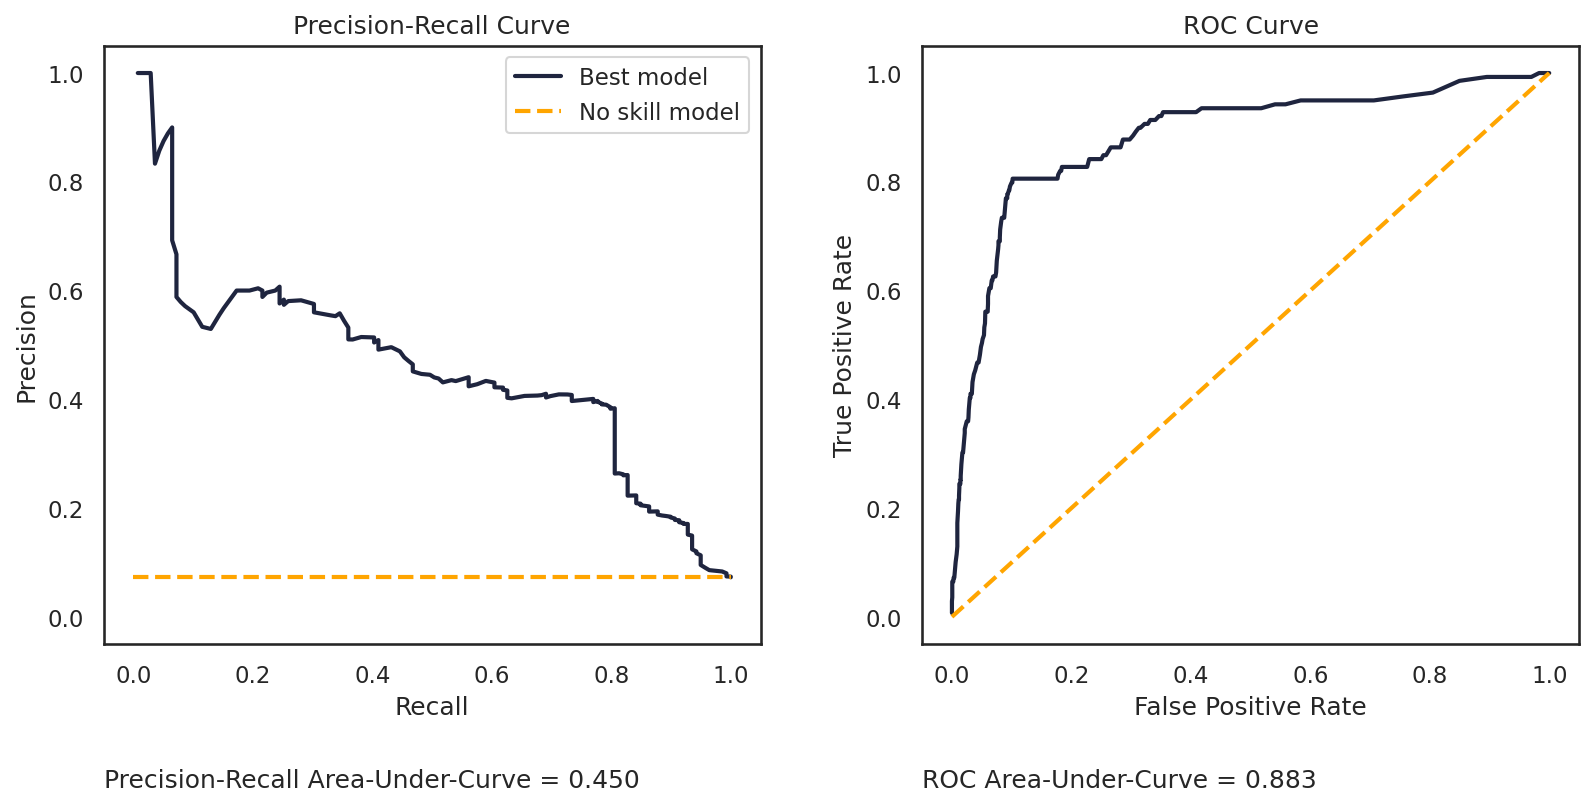

In [ ]:
roc_auc_val = auc(fprs[0, :], tprs[0, :])
pr_auc_val = auc(recalls[0, :], precisions[0, :])

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True, dpi=150)
fig.tight_layout(pad=5.0)

pal = sns.cubehelix_palette(6, rot=-0.25, light=0.7)

axes[0].plot(
    recalls[0, :],
    precisions[0, :],
    marker="",
    label="Best model",
    color=pal[5],
    linewidth=2,
)

axes[0].plot(
    np.array([0, 1]),
    np.array([0.073, 0.073]),
    marker="",
    linestyle="--",
    label="No skill model",
    color="orange",
    linewidth=2,
)

axes[0].legend()
axes[0].title.set_text("Precision-Recall Curve")
axes[0].set_xlabel("Recall")
axes[0].set_ylabel("Precision")
axes[0].text(
    x=-0.05,
    y=-0.3,
    s="Precision-Recall Area-Under-Curve = {:.3f}".format(pr_auc_val),
    horizontalalignment="left",
    verticalalignment="center",
    rotation="horizontal",
    alpha=1,
)

axes[1].plot(
    fprs[0, :], tprs[0, :], marker="", label="Best model", color=pal[5], linewidth=2,
)

axes[1].plot(
    np.array([0, 1]),
    np.array([0, 1]),
    marker="",
    linestyle="--",
    label="No skill",
    color="orange",
    linewidth=2,
)

axes[1].title.set_text("ROC Curve")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].text(
    x=-0.05,
    y=-0.3,
    s="ROC Area-Under-Curve = {:.3f}".format(roc_auc_val),
    horizontalalignment="left",
    verticalalignment="center",
    rotation="horizontal",
    alpha=1,
)

for ax in axes.flatten():
    ax.yaxis.set_tick_params(labelleft=True, which="major")
    ax.grid(False)

plt.show()